#### Reading instance and defining model

In [155]:
# Reading instance

from instanceReaderSMDHPDPTW import Instance

instanceName = "AA10 - Modificada"

MV = 10

n_pickup_sites = 3

fleet_capacities = [10, 20, 10]

vehicle_locations= [[0], [1], [2]]

inst = Instance(instanceName,
                fleet_capacities,
                n_pickup_sites,
                multiple_depots=True,
                vehicle_locations=[[0], [1], [2]])

    solver failure.


In [201]:
# Applying modifications - These would be more suitable on reader!
# but for now, I'll do it like that

# Instance data
df_instance = inst.instance_data
df_instance = df_instance[['type','x','y','d','w_a','w_b']]

# Taking away artificial nodes
valid_types = ['Depot', 'Pickup','Delivery']
df_instance = df_instance[df_instance['type'].isin(valid_types)].reset_index(drop=True)

# Dropping duplicate pickup sites
df_instance = df_instance.drop_duplicates(['type','x']).reset_index(drop=True)

# Multiplying demands by factor
pickup_factor = 10
delivery_factor = 4
df_instance['d'] = [demand*pickup_factor if (demand > 0) else demand*delivery_factor for demand in df_instance['d']]

# Appending back depot nodes at the end
df_instance = df_instance.append(df_instance[df_instance['type'] == 'Depot']).reset_index(drop=True)

In [202]:
# Distances
c = [[0 for i in range(len(df_instance))] for j in range(len(df_instance))]

for i in range(len(df_instance)):
    for j in range(len(df_instance)):
        
        x_i = df_instance.iloc[i]['x']
        x_j = df_instance.iloc[j]['x']
        y_i = df_instance.iloc[i]['y']
        y_j = df_instance.iloc[j]['y']
        
        dist = round(((x_i-x_j)**2 + (y_i-y_j)**2)**(1/2),2)
        c[i][j] = dist
        
# Demands
d = df_instance['d']

# Time windows
w_a = df_instance['w_a']
w_b = df_instance['w_b']

# Capacities
Q = fleet_capacities

In [203]:
import pandas as pd

# Importing pyomo modules

import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory

# Creating model
model = pyo.ConcreteModel()

In [204]:
# Visualizing instance

df_instance.set_index(pd.Index(range(1, len(df_instance) + 1)))

,type,x,y,d,w_a,w_b
1,Depot,19.942,16.269,0.0,0.0,1000.0
2,Depot,29.622,23.653,0.0,0.0,1000.0
3,Depot,39.947,22.762,0.0,0.0,1000.0
4,Pickup,19.942,16.269,70.0,0.0,1000.0
5,Pickup,29.622,23.653,50.0,0.0,1000.0
6,Pickup,39.947,22.762,100.0,0.0,1000.0
7,Delivery,35.573,46.733,-28.0,209.0,269.0
8,Delivery,36.158,11.897,-36.0,562.0,622.0
9,Delivery,43.760,46.624,-60.0,261.0,321.0
10,Delivery,13.387,36.048,-20.0,549.0,609.0


In [245]:
# tw_factor = 0.8

# w_b = [tw*tw_factor if tw == 1000 else tw for tw in w_b]

# w_b

## Defining sets and notation

## $  N = S_{0} \cup P \cup D \cup S_{f} = \{1, ..., 3s + n\} $
## $ S_{0} = \{1, ... , s\} $
## $ P = \{s + 1, ... , 2s\} $
## $ D = \{2s + 1, ... , 2s + n\} $
## $ S_{f} = \{2s + n + 1, ... , 3s + n\} $

#### Vehicles set

## $ \newline K = \{1, ..., m\} $

#### Visits set

## $ \newline V = \{1, ..., MV\} $


In [206]:
# Sets

model.setN = pyo.Set(initialize=range(len(df_instance)))
model.setP = pyo.Set(initialize=df_instance[df_instance['type'] == 'Pickup'].index)
model.setD = pyo.Set(initialize=df_instance[df_instance['type'] == 'Delivery'].index)

# Additional sets

number_of_depots = int(len(df_instance[df_instance['type'] == 'Depot'])/2)
model.setS_0 = pyo.Set(initialize=df_instance[df_instance['type'] == 'Depot'].iloc[:number_of_depots].index)
model.setS_f = pyo.Set(initialize=df_instance[df_instance['type'] == 'Depot'].iloc[-number_of_depots:].index)
model.setS = (model.setS_0 | model.setS_f)


# Set of vehicles
model.setK = pyo.Set(initialize=range(len(fleet_capacities)))

# Set of visits
model.setV = pyo.Set(initialize=range(MV))

#### Defining variables

### $x_{ijkv} = \text{1 if vehicle $k$ travels from $i$ to $j$ in its $v$ visit and 0 otherwise;} $

### $y_{ikv} = \text{amount of load in vehicle $k$ after visiting node $i$ in its $v$ visit;} $

### $w_{ikv} = \text{arrival time of vehicle $k$ in node $i$ in its $v$ visit;} $

### $z_{ikv} = \text{amount of load supplied/delivered by vehicle $k$ to node $i$ in its $v$ visit;} $

In [207]:
# Variables

model.x = pyo.Var(model.setN, model.setN, model.setK, model.setV, within = pyo.Binary)

model.y = pyo.Var(model.setN, model.setK, model.setV, within = NonNegativeReals)

model.w = pyo.Var(model.setN, model.setK, model.setV, within = NonNegativeReals)

model.z = pyo.Var(model.setN, model.setK, model.setV, within = NonNegativeReals)

#### Defining constraints

#### Objective function

## $ (1) $

## $$ max \displaystyle \sum_{i \in D}\displaystyle \sum_{i \in K}\displaystyle \sum_{j \in V}z_{ikv}$$

In [208]:
# (1) - Objective function

model.exprobj = sum(sum(sum(model.z[i,k,v] for i in model.setD) for k in model.setK) for v in model.setV)

model.obj = pyo.Objective(expr= model.exprobj, sense = pyo.maximize)

## $ (2) $

## $$\displaystyle \sum_{i \in N}\displaystyle \sum_{v \in V}x_{ijkv} \leq \frac{MV}{2}, \hspace{15pt} \forall j \in P \cup D, k \in K$$

In [209]:
# (2) - Maximum number of visits in a node must be MV/2, which would be sucessive back and forth trips

model.R2 = pyo.ConstraintList()

for j in (model.setP | model.setD):
    
    for k in model.setK:
    
        model.R2.add(expr = sum(sum(model.x[i,j,k,v] for i in model.setN) for v in model.setV) <= MV/2)

## $ (3) $


## $$ \displaystyle \sum_{i \in N \setminus S_{f}}x_{ihk(v-1)} -  \displaystyle \sum_{j \in N \setminus S_{0}}x_{hjkv} = 0, \hspace{15pt} \forall h \in P \cup D, k \in K, v \in V \setminus \{0\} $$

In [210]:
# (3) - Flow conservation - if vehicle k goes from i to h, it has to go from h to j on the next visit

model.R3 = pyo.ConstraintList()

for h in (model.setP | model.setD):
    
    for k in model.setK:
        
        for v in range(1,len(model.setV)):

            model.R3.add(expr = sum(model.x[i,h,k,v-1] for i in (model.setN - model.setS_f)) - sum(model.x[h,j,k,v] for j in (model.setN - model.setS_0)) == 0)


## $ (4) $



## $$ \displaystyle \sum_{i \in N}\sum_{j \in N}\sum_{v \in V}x_{ijkv} \leq MV, \hspace{15pt} \forall k \in K$$

In [211]:
# (4) - Vehicles can visit "MV" arcs in their routes at most

model.R4 = pyo.ConstraintList()
    
for k in model.setK:

        model.R4.add(expr = sum(sum(sum(model.x[i,j,k,v] for i in model.setN) for j in model.setN) for v in model.setV) <= MV)

## $ (5) $



## $$ \displaystyle x_{ijk0} = 0, \hspace{15pt} \forall i \in N \setminus S_{0} , j \in N , k \in K $$

In [212]:
# (5) - Vehicles must depart from depot

model.R5 = pyo.ConstraintList()

for i in (model.setN - model.setS_0):
    
    for j in model.setN:
    
        for k in model.setK:
        
            model.R5.add(expr = model.x[i,j,k,0] == 0)

## $ (6) $



## $$ \displaystyle x_{ijkMV} = 0, \hspace{15pt} \forall j \in N \setminus S_{f} , i \in N , k \in K $$

In [213]:
# (6) - Vehicles must end their routes in one of the available depots

model.R6 = pyo.ConstraintList()

for i in model.setN:
    
    for j in (model.setN - model.setS_f):
    
        for k in model.setK:
        
            model.R6.add(expr = model.x[i,j,k,model.setV.bounds()[1]] == 0)

## $ (7) $


## $$ \displaystyle x_{ijk0} = 0,  \hspace{15pt} \forall i \in S_{0}; j \in N \setminus D_{i}; k \in K$$

In [214]:
# (7) - A vehicle can't depart from a depot that is not its initial depot

model.R7 = pyo.ConstraintList()

for i in model.setS_0:

    for j in model.setN:
        
        for k in model.setK:
            
            if (k not in vehicle_locations[i]):
                       
                model.R7.add(expr = model.x[i, j, k, 0] == 0) 

## $ (8) $

## $$ \displaystyle \sum_{j \in N}\sum_{k \in K}x_{ijk0} \leq K_{i}, \hspace{15pt} \forall i \in S_{0} $$

In [215]:
# (8) - Number of vehicles that depart from depot must be equal to number of vehicles available at depot

# K_{i} - Number of vehicles that start their route at depot i in S_0

K = [len(location) for location in vehicle_locations]

model.R8 = pyo.ConstraintList()

for i in (model.setS_0):

    model.R8.add(expr = sum(sum(model.x[i,j,k,0] for j in model.setN) for k in model.setK) <= K[i])

## $ (9) $



## $$ \displaystyle x_{ijkv} = 0, \hspace{15pt} \forall i \in S_{0}, j \in D , k \in K, v \in V $$

In [216]:
# (9) - Vehicles can't go from depot directly to a delivery node (was this supposed to be a constraint?)

model.R9 = pyo.ConstraintList()

for i in model.setS_0:
    
    for j in model.setD:
    
        for k in model.setK:
            
            for v in model.setV:
        
                model.R9.add(expr = model.x[i,j,k,v] == 0)

## $ (10) $

## $$ w_{jkv} \geq w_{ik(v-1)} + t_{ij} - M(1-x_{ijkv}), \newline\forall i \in N, j \in N, k \in K, v \in V \setminus\{0\} $$

In [217]:
# (10) - Time windows constraints - 1

# Defining big M

M = 1000

model.R10 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setN:
        
        for k in model.setK:
    
            for v in range(1, len(model.setV)):
        
                model.R10.add(expr = model.w[j, k, v] >= model.w[i, k, v-1] + c[i][j] - M*(1 - model.x[i,j, k, v]))
            
                model.R10.add(expr = model.w[j, k, v] <= model.w[i, k, v-1] + c[i][j] + M*(1 - model.x[i,j, k, v]))

## $ (11) $



## $$ w_{i}^{a} \leq w_{ikv} \leq w_{i}^{b} , \hspace{15pt} \forall i \in P \cup D, k \in K, v \in V $$

In [218]:
# (11)  - Time windows constraints - 2

model.R11 = pyo.ConstraintList()

for i in (model.setP | model.setD):
    
    for k in model.setK:
        
        for v in model.setV:
    
            model.R11.add(expr = model.w[i, k, v] >= w_a[i])
            model.R11.add(expr = model.w[i, k, v] <= w_b[i])

## $ (12) $



## $$ y_{jkv} \geq y_{ik(v-1)} + z_{jkv} - M(1-x_{ijkv}), \newline\forall i \in N, j \in P, k \in K, v \in V \setminus \{0\} $$

In [219]:
# (12) - Load constraints - 1 (pickup)

model.R12 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setP:
        
        for k in model.setK:
    
            for v in range(1, len(model.setV)):
        
                model.R12.add(expr = model.y[j,k,v] >= model.y[i,k,v-1] + model.z[j,k,v] - M*(1 - model.x[i,j,k,v]))
            
                model.R12.add(expr = model.y[j,k,v] <= model.y[i,k,v-1] + model.z[j,k,v] + M*(1 - model.x[i,j,k,v]))
                
# (12) - Load constraints - 1 (pickup)

for i in model.setN:
        
    for k in model.setK:

            model.R12.add(expr = model.y[i,k,0] >= model.z[i,k,0])

            model.R12.add(expr = model.y[i,k,0] <= model.z[i,k,0])

## $ (13) $



## $$ y_{jkv} \geq y_{ik(v-1)} - z_{jkv} - M(1-x_{ijkv}), \newline\forall i \in N, j \in D, k \in K, v \in V \setminus \{0\} $$

In [220]:
# (13)  - Load constraints - 2 (delivery)

model.R13 = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setD:
        
        for k in model.setK:
    
            for v in range(1, len(model.setV)):
            
                model.R13.add(expr = model.y[j,k,v] >= model.y[i,k,v-1] - model.z[j,k,v] - M*(1 - model.x[i,j,k,v]))
                
                model.R13.add(expr = model.y[j,k,v] <= model.y[i,k,v-1] - model.z[j,k,v] + M*(1 - model.x[i,j,k,v]))

## $ (14) $



## $$ \displaystyle y_{ikv} \leq Q_{k}, \hspace{15pt} \forall i \in N , k \in K, v \in V$$

In [221]:
# (14) - Load constraints - 3

model.R14 = pyo.ConstraintList()

for i in model.setN:

        for k in model.setK:

            for v in model.setV:

                model.R14.add(expr = model.y[i,k,v] <= Q[k])


## $ (15) $


## $$ \displaystyle \sum_{k \in K}\sum_{v \in V} z_{ikv} \leq d_{i}, \hspace{15pt} \forall i \in P \cup D $$

In [222]:
# (15)  - Total amount picked up/delivered to each node can't be above node supply/demand

model.R15 = pyo.ConstraintList()

for i in (model.setP | model.setD):

    model.R15.add(expr = sum(sum(model.z[i, k, v] for k in model.setK) for v in model.setV) <= abs(d[i]))

## $ (16) $


## $$  z_{ikv} \leq d_{i}\displaystyle \sum_{j \in N}x_{jikv}, \hspace{15pt} \forall i \in N, k \in K, v \in V $$

In [223]:
# (16) - Amount delivered to a node in a single visit can't exceed node demand

model.R16 = pyo.ConstraintList()

for i in model.setN:
    
    for k in model.setK:
        
        for v in model.setV:

            model.R16.add(expr = model.z[i, k, v] <= abs(d[i])*sum(model.x[j,i,k,v] for j in model.setN))

## $ (17) $


## $$  \displaystyle \sum_{i \in P}\sum_{v \in V} z_{ikv} =\displaystyle \sum_{i \in D}\sum_{v \in V}z_{ikv}, \forall k \in K$$

In [224]:
# (17) - Total delivered amount by a vehicle needs to be equal to total picked up demand

model.R17 = pyo.ConstraintList()

for k in model.setK:
    
    model.R17.add(expr = sum(sum(model.z[i, k, v] for i in model.setP) for v in model.setV) == sum(sum(model.z[i, k, v] for i in model.setD) for v in model.setV))


## $ (18) $


## $$  z_{ik0} \leq Q_{k}, \hspace{15pt} \forall i \in N, k \in K$$

In [225]:
# # (18)  - Amount collected/delivered at the first visit can't exceed vehicle capacity

# # Also needed because of problems with Y and Z for first visit

# model.R18 = pyo.ConstraintList()

# for i in model.setN:
    
#     for k in model.setK:

#         model.R18.add(expr = model.z[i,k,0] <= Q[k])

In [226]:
# # (19) - Forces that a vehicle can't go to a pickup node that is not in the same place of its initial depot

# # Can be turned off, if convenient in some way

# model.R22 = pyo.ConstraintList()

# for i in model.setS_0:

#     for j in model.setP:
        
#         for k in model.setK:
            
#             if (c[i][j] > 0):

#                 model.R22.add(expr = model.x[i, j, k, 0] == 0)

#### Valid inequalities

In [227]:
# # Inequalities for N set

model.VI1 = pyo.ConstraintList()

# No "node to initial depot" arcs or "final depot to nodes" arcs

for i in model.setN:
    
    for k in model.setK:
        
        for v in model.setV:
    
            #model.VI1.add(expr= model.x[i, i, k, v] == 0)

            for h in model.setS_0:

                model.VI1.add(expr= model.x[i, h, k, v] == 0)

            for h in model.setS_f:

                model.VI1.add(expr= model.x[h, i, k, v] == 0)
                

# Vehicles can't visit pickup node right before ending route

model.RV2 = pyo.ConstraintList()

for i in model.setP:
    
    for j in model.setS_f:
    
        for k in model.setK:
        
            model.RV2.add(expr = model.x[i,j,k,model.setV.bounds()[1]] == 0)


# Time windows inequalities

model.VI3 = pyo.ConstraintList()

for i in (model.setP | model.setD):
    
    for j in (model.setP | model.setD):
        
        for k in model.setK:
            
            for v in model.setV:
        
                if w_a[i] + c[i][j] > w_b[j]:

                    model.VI3.add(expr= model.x[i, j, k, v] == 0)

                    
# Delivery capacities inequalities

model.VI4 = pyo.ConstraintList()

for i in model.setD:
    
    for j in model.setD:
        
        for k in model.setK:
            
            for v in model.setV:
        
                if (abs(d[i]) + abs(d[j]) > Q[k]):
            
                    model.VI4.add(expr= model.x[i, j, k, v] == 0)
                
# # (ZZ) - No "initial depot to final depot" arcs

# model.RZZ = pyo.ConstraintList()

# for i in model.setS_0:
    
#     for j in model.setS_f:
        
#         for k in model.setK:

#             for v in model.setV:

#                 model.RZZ.add(expr = model.x[i, j, k, v] == 0)
        

In [228]:
# (YY)

model.RYY = pyo.ConstraintList()
        
for k in model.setK:
    
    for v in model.setV:

        model.RYY.add(expr = sum(sum(model.x[i, j, k, v] for i in model.setN) for j in model.setN) <= 1)

In [229]:
model.RMM = pyo.ConstraintList()

for i in model.setN:
        
    for k in model.setK:
        
        for v in model.setV:

            model.RMM.add(expr = model.z[i,k,v] <= M*(1-model.x[i, i, k, v]))
            model.RMM.add(expr = model.z[i,k,v] >= (-1)*M*(1-model.x[i, i, k, v]))
        

In [230]:
# No nodes going to final depot in visits lower than MV

model.RXYZ = pyo.ConstraintList()

for i in model.setN:
    
    for j in model.setS_f:
        
        for k in model.setK:

            for v in range(len(model.setV) - 1):

                model.RXYZ.add(expr = model.x[i, j, k, v] == 0)
                
# No nodes starting on initial depots in visits higher than 0

for i in model.setS_0:
    
    for j in model.setN:
        
        for k in model.setK:

            for v in range(1, len(model.setV)):

                model.RXYZ.add(expr = model.x[i, j, k, v] == 0)


In [231]:
# # "Equity" constraint

# demand_fraction = 0.05

# model.REQ = pyo.ConstraintList()

# for i in model.setD:
    
#     model.REQ.add(expr= sum(sum(model.z[i,k,v] for k in model.setK) for v in model.setV) >= abs(d[i])*demand_fraction)

#### Solving model

In [232]:
# Solver

TimeLimit = 600

opt = pyo.SolverFactory('cplex', executable='C:/Program Files/IBM/ILOG/CPLEX_Studio201/cplex/bin/x64_win64/cplex')
opt.options['TimeLimit'] = TimeLimit


results = opt.solve(model, tee=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\User\AppData\Local\Temp\tmpz5ujms0d.cplex.log' open.
CPLEX> New value for time limit in seconds: 600
CPLEX> Problem 'C:\Users\User\AppData\Local\Temp\tmpa0f4n3xz.pyomo.lp' read.
Read time = 0.09 sec. (5.09 ticks)
CPLEX> Problem name         : C:\Users\User\AppData\Local\Temp\tmpa0f4n3xz.pyomo.lp
Objective sense      : Maximize
Variables            :   12541  [Nneg: 1711,  Binary: 10830]
Objective nonzeros   :     300
Linear constraints   :   49982  [Less: 35704,  Greater: 390,  Equal: 13888]
  Nonzeros           :  178459
  RHS nonzeros       :   35321

Variables            : Min LB: 

In [243]:
for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if (pyo.value(model.x[i,j,k,v]))>0.01:

                    print(f'x[{i}, {j}, {k}, {v}] == {pyo.value(model.x[i,j,k,v])}')

x[0, 5, 0, 0] == 1.0
x[5, 13, 0, 1] == 1.0
x[13, 3, 0, 2] == 1.0
x[3, 5, 0, 3] == 1.0
x[5, 10, 0, 4] == 1.0
x[10, 5, 0, 5] == 1.0
x[5, 12, 0, 6] == 1.0
x[12, 3, 0, 7] == 1.0
x[3, 7, 0, 8] == 1.0
x[7, 18, 0, 9] == 1.0
x[1, 5, 1, 0] == 1.0
x[5, 14, 1, 1] == 1.0
x[14, 5, 1, 2] == 1.0
x[5, 14, 1, 3] == 1.0
x[14, 3, 1, 4] == 1.0
x[3, 15, 1, 5] == 1.0
x[15, 4, 1, 6] == 1.0
x[4, 5, 1, 7] == 1.0
x[5, 6, 1, 8] == 1.0
x[6, 18, 1, 9] == 1.0
x[2, 5, 2, 0] == 1.0
x[5, 13, 2, 1] == 1.0
x[13, 3, 2, 2] == 1.0
x[3, 10, 2, 3] == 1.0
x[10, 4, 2, 4] == 1.0
x[4, 9, 2, 5] == 1.0
x[9, 4, 2, 6] == 1.0
x[4, 3, 2, 7] == 1.0
x[3, 7, 2, 8] == 1.0
x[7, 17, 2, 9] == 1.0


In [234]:
for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if ((pyo.value(model.x[i,j,k,v]))>0.01):

                    print(f'z[{j}, {k}, {v}] == {pyo.value(model.z[j,k,v])}')

z[5, 0, 0] == 10.0
z[13, 0, 1] == 10.000000000000002
z[3, 0, 2] == 0.0
z[5, 0, 3] == 10.000000000000002
z[10, 0, 4] == 10.0
z[5, 0, 5] == 10.0
z[12, 0, 6] == 10.0
z[3, 0, 7] == 10.0
z[7, 0, 8] == 10.0
z[18, 0, 9] == 0.0
z[5, 1, 0] == 20.0
z[14, 1, 1] == 20.0
z[5, 1, 2] == 20.0
z[14, 1, 3] == 20.0
z[3, 1, 4] == 20.000000000000004
z[15, 1, 5] == 20.000000000000004
z[4, 1, 6] == 20.000000000000004
z[5, 1, 7] == 0.0
z[6, 1, 8] == 20.000000000000004
z[18, 1, 9] == 0.0
z[5, 2, 0] == 20.0
z[13, 2, 1] == 20.0
z[3, 2, 2] == 20.000000000000004
z[10, 2, 3] == 20.0
z[4, 2, 4] == 20.000000000000004
z[9, 2, 5] == 20.0
z[4, 2, 6] == 0.0
z[3, 2, 7] == 20.000000000000004
z[7, 2, 8] == 20.000000000000004
z[17, 2, 9] == 0.0


In [235]:
for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if ((pyo.value(model.x[i,j,k,v]))>0.01):

                    print(f'y[{j}, {k}, {v}] == {pyo.value(model.y[j,k,v])}')

y[5, 0, 0] == 10.0
y[13, 0, 1] == 0.0
y[3, 0, 2] == 0.0
y[5, 0, 3] == 10.0
y[10, 0, 4] == 0.0
y[5, 0, 5] == 10.0
y[12, 0, 6] == 0.0
y[3, 0, 7] == 10.0
y[7, 0, 8] == 0.0
y[18, 0, 9] == 0.0
y[5, 1, 0] == 20.0
y[14, 1, 1] == 0.0
y[5, 1, 2] == 20.0
y[14, 1, 3] == 0.0
y[3, 1, 4] == 20.000000000000004
y[15, 1, 5] == 0.0
y[4, 1, 6] == 20.000000000000227
y[5, 1, 7] == 20.000000000000227
y[6, 1, 8] == 0.0
y[18, 1, 9] == 0.0
y[5, 2, 0] == 20.0
y[13, 2, 1] == 0.0
y[3, 2, 2] == 20.0
y[10, 2, 3] == 0.0
y[4, 2, 4] == 20.0
y[9, 2, 5] == 0.0
y[4, 2, 6] == 0.0
y[3, 2, 7] == 20.0
y[7, 2, 8] == 0.0
y[17, 2, 9] == 0.0


In [236]:
for k in model.setK:

    for v in model.setV:

        for i in model.setN:
            
            for j in model.setN:
            
                if pyo.value(model.x[i,j,k,v]) > 0.01:

                    print(f'w[{j}, {k}, {v}] == {pyo.value(model.w[j,k,v])}')
                    

w[5, 0, 0] == 420.77
w[13, 0, 1] == 443.4
w[3, 0, 2] == 451.99
w[5, 0, 3] == 473.02
w[10, 0, 4] == 494.74
w[5, 0, 5] == 516.46
w[12, 0, 6] == 545.0
w[3, 0, 7] == 564.97
w[7, 0, 8] == 581.77
w[18, 0, 9] == 593.28
w[5, 1, 0] == 58.57000000000005
w[14, 1, 1] == 63.34000000000003
w[5, 1, 2] == 68.11000000000001
w[14, 1, 3] == 72.88
w[3, 1, 4] == 96.82000000000005
w[15, 1, 5] == 135.24000000000012
w[4, 1, 6] == 174.2700000000001
w[5, 1, 7] == 184.6300000000001
w[6, 1, 8] == 209.0
w[18, 1, 9] == 233.37
w[5, 2, 0] == 466.1400000000001
w[13, 2, 1] == 488.7700000000001
w[3, 2, 2] == 497.3600000000001
w[10, 2, 3] == 515.2800000000001
w[4, 2, 4] == 528.57
w[9, 2, 5] == 549.0
w[4, 2, 6] == 569.43
w[3, 2, 7] == 581.5999999999999
w[7, 2, 8] == 598.3999999999999
w[17, 2, 9] == 611.8499999999999


In [237]:
# Getting routes on solution

routes = [[] for k in model.setK]

for k in model.setK:
    
    for v in model.setV:

        for i in model.setN:

            for j in model.setN:

                if (pyo.value(model.x[i,j,k,v]))>0.01:
                    
                    if len(routes[k]) == 0:
                    
                        routes[k].extend([i,j])
                        
                    else:
                        
                        routes[k].append(j)

print(routes)

[[0, 5, 13, 3, 5, 10, 5, 12, 3, 7, 18], [1, 5, 14, 5, 14, 3, 15, 4, 5, 6, 18], [2, 5, 13, 3, 10, 4, 9, 4, 3, 7, 17]]


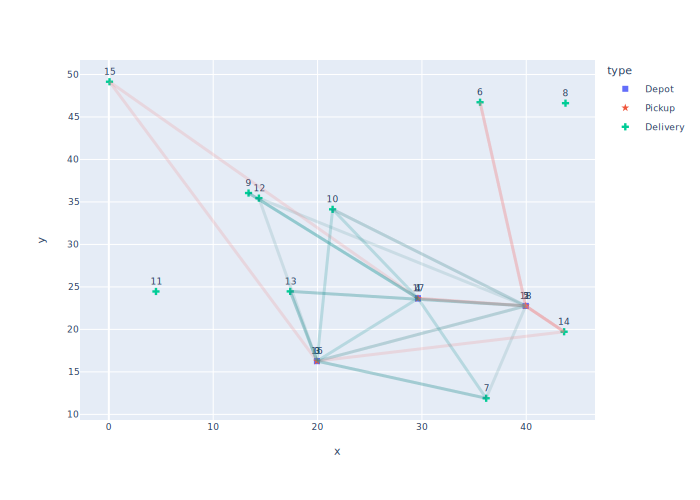

In [251]:
import plotly.express as px
import plotly.graph_objects as go
import matplotlib, random

random.seed(123)
colors = dict(matplotlib.colors.cnames.items())

hex_colors = tuple(colors.values())


fig = px.scatter(df_instance,x="x", y="y", symbol='type', symbol_sequence=["square","star","cross", "star", "x"], color='type', text=df_instance.index, hover_data={"x":False, "y":False,  "d":True, "type":True, "index":df_instance.index})

fig.update_traces(textposition='top center')

fig.update_layout(font=dict(size=9))

# Create scatter trace of text labels

for route in routes:
    
    color = random.choice(hex_colors)
    
    for index_node in range(1, len(route)):
        
        fig.add_shape(type="line",
            x0=df_instance.iloc[route[index_node-1]].x, 
            y0=df_instance.iloc[route[index_node-1]].y,
            x1=df_instance.iloc[route[index_node]].x,
            y1=df_instance.iloc[route[index_node]].y,

            line=dict(color=color,width=3), 
            opacity = 0.2,
            visible = True
        )
        

fig.show("svg")

In [246]:
# import numpy as np

# np.mean([np.mean([el for el in c[i] if el > 0]) for i in range(len(c))])

In [247]:
# w_b[0]/np.mean([np.mean([el for el in c[i] if el > 0]) for i in range(len(c))])

In [248]:
# np.mean([demanda/10 for demanda in abs(d) if demanda > 0])*2

In [249]:
# np.sum([demanda/10 for demanda in abs(d) if demanda > 100])